In [2]:
import pandas as pd

import numpy as np

import seaborn as sns

import plotly.express as px

from sklearn.dummy import DummyClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import *

from sklearn.utils import shuffle

import matplotlib.pyplot as plt

# Отток клиентов

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Разбиение-выборок-и-масштабирование-признаков" data-toc-modified-id="Разбиение-выборок-и-масштабирование-признаков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разбиение выборок и масштабирование признаков</a></span></li><li><span><a href="#Обучение-модели-без-учета-дисбаланса" data-toc-modified-id="Обучение-модели-без-учета-дисбаланса-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение модели без учета дисбаланса</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Up-sampling" data-toc-modified-id="Up-sampling-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Up-sampling</a></span></li><li><span><a href="#Down-sampling" data-toc-modified-id="Down-sampling-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Down-sampling</a></span></li><li><span><a href="#class_weight-=-'balanced'" data-toc-modified-id="class_weight-=-'balanced'-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>class_weight = 'balanced'</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод:</a></span></li></ul></div>

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Загрузим данные и посмотрим на их характеристики.

In [3]:
start_data = pd.read_csv('Churn.csv')

In [4]:
start_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
print(start_data.duplicated().sum())

0


In [6]:
start_data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


В нашем датасете 14 колонок:

Признаки:
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — количество недвижимости у клиента
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

Целевой признак:
- `Exited` — факт ухода клиента

`RowNumber`, `CustomerId` и `Surname` можно убрать из таблицы - они не несут в себе информации полезной для нашего исследования. Врядли факт ухода клиента из банка коррелируется с его фамилией или порядковым номером в системе банка.

Столбец `Tenure` имеет пропуски и записан в формате чисел с плавающей точкой. Пропуски скорее всего возникли в результате того, что некоторые операторы, заполнявшие анкеты, пропускали этот пункт, если у человека нет недвижимости. Логично заполнить пропуски нулями и привести столбец к целочисленному формату.

Так же у нас имеется несколько столбцов с категориальными данными, которые нам надо подменить на числовые значения. 

In [7]:
start_data.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1, inplace=True)

start_data.columns = map(str.lower, start_data.columns)
print(start_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           9091 non-null   float64
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB
None


In [8]:
start_data['tenure'].fillna(0, inplace=True)

start_data = start_data.astype({'tenure':'int'})

print(start_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  int32  
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(2), int32(1), int64(6), object(2)
memory usage: 820.4+ KB
None


In [9]:
start_data['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

В столбце с геграфией клиента всего три вида Уникальных значений. Используем для этого столбца и для столбца с полом клиента технику прямого кодирования. Чтобы избежать дамми-ловушку будем передовать аргументом функции `drop_first=True`.

In [11]:
start_data_ohe = pd.get_dummies(start_data, drop_first=True)

In [12]:
start_data_ohe.head(5)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Посмотрим, что у нас находится в столбцах с количественными признаками. Напишем функцию, которая нарисует нам распределение этих признаков, чтобы оценить нет ли у нас выбросов или каких-либо еще артефактов, которые могут повлиять на качество нашей модели.

In [13]:
def histogram_boxplot(data,
                      xlabel=None,
                      title=None,
                      font_scale=1,
                      figsize=(16, 8),
                      bins=None):
    """ Диграмма размаха и гистограмма будут отрисованны вместе на одном кадре. 
    На графиках будут также нарисованны линия среднего и медианы.
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 1)
    figsize: size of fig (default (16, 8))
    bins: number of bins (default None / auto)
    """
    
    sns.set(font_scale=font_scale)
    
    f2, (ax_box2, ax_hist2) = plt.subplots(
        2,
        sharex=True,
        gridspec_kw={"height_ratios": (.15, .85)},
        figsize=figsize
    )
    sns.boxplot(x=data, ax=ax_box2)
    
    if bins:
        sns.histplot(x=data, ax=ax_hist2, bins=bins, kde=True)
    else:
        sns.histplot(data, ax=ax_hist2, kde=True)

    plt.axvline(x=data.mean(), linewidth=2, color='r', label="mean", alpha=0.8)
    plt.axvline(x=data.median(),
                linewidth=2,
                color='y',
                label="median",
                alpha=0.8)
    ax_hist2.legend()

    if xlabel:
        ax_hist2.set(xlabel=xlabel)
    if title:
        ax_box2.set(title=title)
    plt.show()    

In [14]:
def info_column(column_name, data, bins=None):
    
    '''Функция смотри тип данных в столбце:
    - если тип object, то смотрит уникальные значения
    - в противном случае оценивается распределение'''
    
    if column_name.dtype == 'object':
        
        print(column_name.name)
        print(column_name.unique())
        print()
        print(column_name.describe())
        print()
        
    else:
        bins=bins
        print(column_name.name)
        print(column_name.describe())
        histogram_boxplot(column_name, xlabel=column_name.name, title = 'Распределение '+ column_name.name)        

creditscore
count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: creditscore, dtype: float64


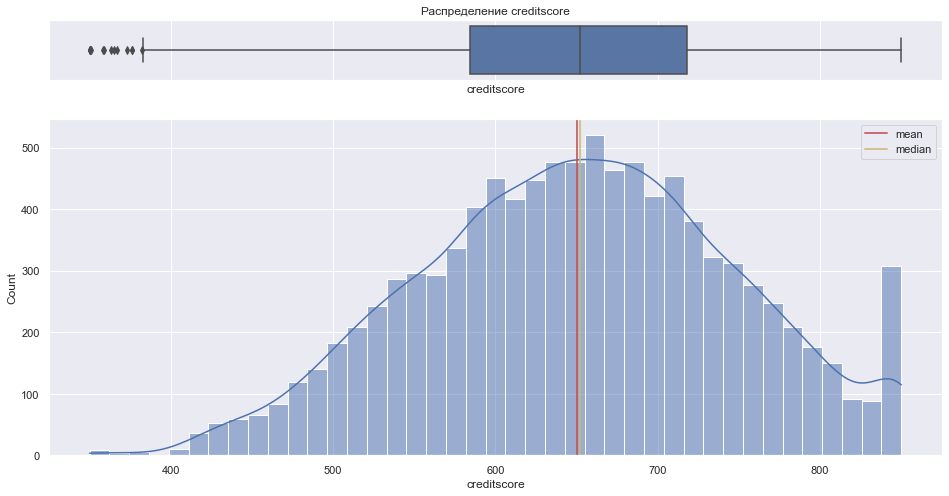

age
count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64


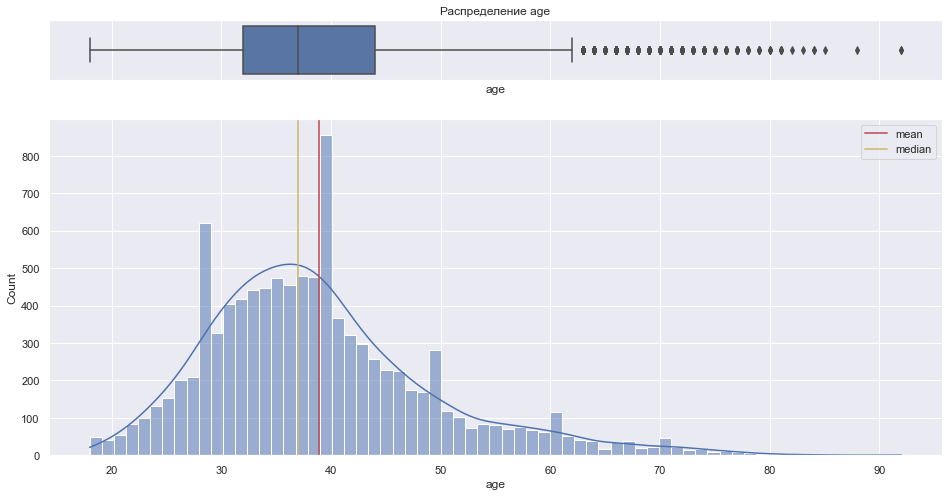

balance
count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64


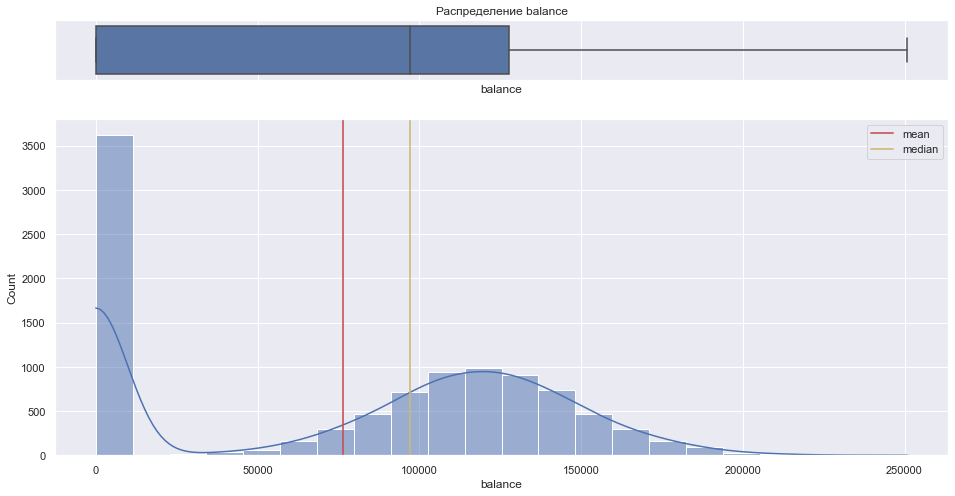

estimatedsalary
count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimatedsalary, dtype: float64


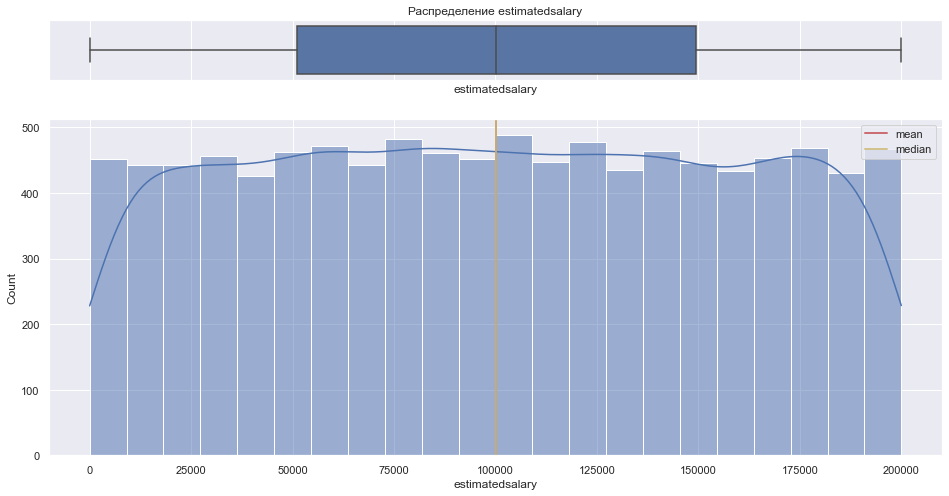

numofproducts
count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: numofproducts, dtype: float64


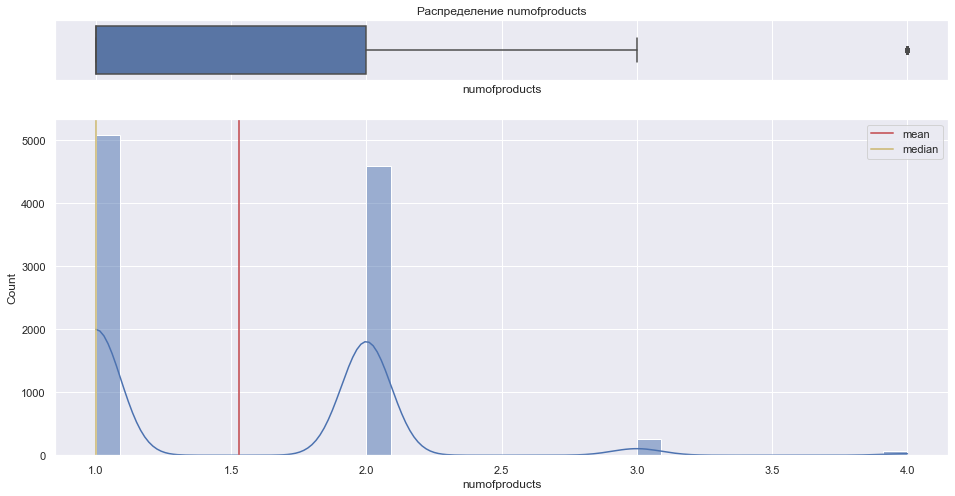

tenure
count    10000.000000
mean         4.543400
std          3.111573
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         10.000000
Name: tenure, dtype: float64


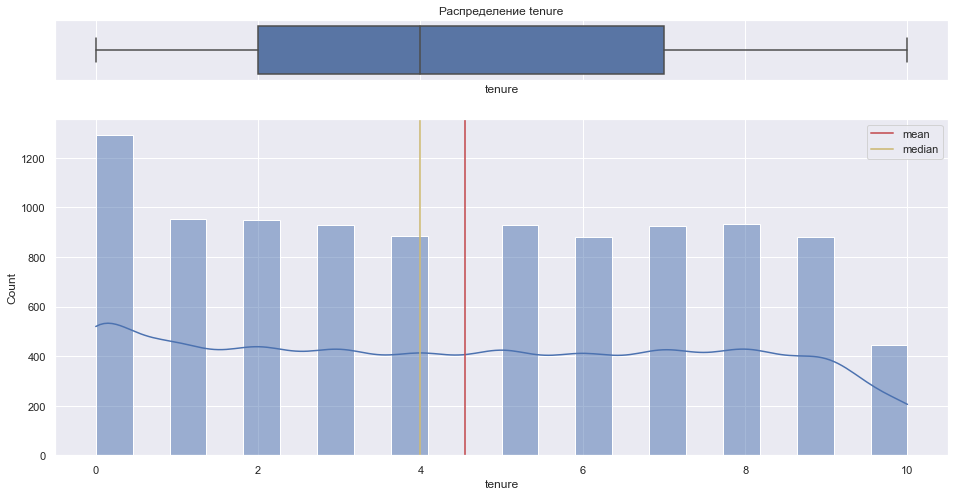

In [15]:
numeric = ['creditscore', 'age', 'balance', 'estimatedsalary', 'numofproducts', 'tenure']

for column in numeric:
    info_column(start_data[column], start_data)

Из осмотра количественных данных можно сделать следующие наблюдения:
- 233 человека вызывают повышенную симпатию со стороны банка и имеют максимальный кредитный рейтинг. Совсем немного, и скорее всего они лояльные клинеты. Есть небольшой выброс с очень маленьким рейтингом, но они не должны повлиять на нашу выборку.
- 3617 человек не держат деньги на счету в этом банке. Вероятно они либо пользуются исключительно кредитными продуктами банка, либо счет у них остался, потому что они слишком ленивы, чтобы закрывать его. Интуиция подсказывает, что как раз они должны быть из группы риска. Но это только интуиция. Тем не менее, мы не будем ничего предпринимать, чтобы отдельно обработать эти данные.

**Вывод по шагу 1:**

Мы проверили нашу таблицу и предобработали данные:
- стандартизировали названия столбцов
- исключили бесполезные данные из нашего набора
- заполнили пропуски и привели данные к нужному типу
- заменили категориальные данные на числовые методом прямого кодирования

Теперь нам надо разделить данные и подготовить их к обучению модели.

##  Исследование задачи

### Разбиение выборок и масштабирование признаков

Для начала разобьем нашу таблицу и выделим признаки и целевой признак, а так же сразу разделим данные на обучающие и тестовые. Напишем для этого отдельную функцию.

In [17]:
def split_df_classification(df, target_column_name:str, valid_test_flag:bool):
    
    '''
    This function takes dataframe, target column name and a flag, which means should it return train-valid-test df's 
    (features_train, features_valid, features_test and target_train, target_valid, target_test) or only train-test.
    In case if flag = False, than the function will split the df in proportion 75/25, if True - 60/20/20.
    All splits will be stratified by a target column.
    '''
    
    from sklearn.model_selection import train_test_split
    
    if valid_test_flag:
        df_train, df_valid = train_test_split(df, test_size=0.2, 
                                              random_state=12345, 
                                              stratify = df[target_column_name])
        df_train, df_test = train_test_split(df_train, test_size=0.25, 
                                             random_state=12345, 
                                             stratify = df_train[target_column_name])
        
        features_train = df_train.drop([target_column_name], axis=1)
        target_train = df_train[target_column_name]
        
        features_valid = df_valid.drop([target_column_name], axis=1)
        target_valid = df_valid[target_column_name]
        
        features_test = df_test.drop([target_column_name], axis=1)
        target_test = df_test[target_column_name]
        
        return features_train, features_valid, features_test, target_train, target_valid, target_test
    
    df_train, df_test = train_test_split(df, test_size=0.25, random_state=12345, stratify = df[target_column_name])
    
    features_train = df_train.drop([target_column_name], axis=1)
    target_train = df_train[target_column_name]
    
    features_test = df_test.drop([target_column_name], axis=1)
    target_test = df_test[target_column_name]
    
    return features_train, features_test, target_train, target_test


Разделим первоначальную выборку на тренировочную, валидационную и тестовую.

In [18]:
features_train, features_valid, features_test, target_train, target_valid, target_test = split_df_classification(
    start_data_ohe, 'exited', True)

In [19]:
print('Размер первоначального набора данных:', start_data_ohe.shape[0], 'строк')
print('Размер обучающей выборки: {:.2%}'.format(features_train.shape[0]/start_data_ohe.shape[0]))
print('Размер валидационной выборки: {:.2%}'.format(features_valid.shape[0]/start_data_ohe.shape[0]))
print('Размер тестовой выборки: {:.2%}'.format(features_test.shape[0]/start_data_ohe.shape[0]))

Размер первоначального набора данных: 10000 строк
Размер обучающей выборки: 60.00%
Размер валидационной выборки: 20.00%
Размер тестовой выборки: 20.00%


Посмотрим на баланс классов в наших выборках. Нас интересует как само соотношение классов целевого признака, так и сохранение этого соотношения в разделенных выборках.

In [20]:
dfs = [target_train, target_valid, target_test]

for df in dfs:
    print()
    print('Количество элементов целевого признака составляет {:.2%} от всей выборки'.format(df.mean()))


Количество элементов целевого признака составляет 20.38% от всей выборки

Количество элементов целевого признака составляет 20.35% от всей выборки

Количество элементов целевого признака составляет 20.35% от всей выборки


Отлично, нам удалось сохранить соотношение целевого признака для всех выборок. 

Сделаем масштабирование признаков.

In [21]:
features_train.head(5)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
5536,636,45,0,0.00,2,1,1,159463.80,0,1,1
8530,808,33,2,103516.87,1,1,0,113907.80,0,0,0
1762,758,34,1,154139.45,1,1,1,60728.89,0,0,0
9090,809,39,5,0.00,1,1,0,77705.75,0,0,0
8777,603,24,1,165149.13,2,1,0,21858.28,0,1,1


In [22]:
numeric = ['creditscore', 'age', 'balance', 'estimatedsalary', 'numofproducts', 'tenure']

dfs = [features_train, features_valid, features_test]

scaler = StandardScaler() 
scaler.fit(features_train[numeric])

for df in dfs:
    df[numeric] = scaler.transform(df[numeric])
    display(df.head(5))

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
5536,-0.143332,0.577533,-1.456283,-1.220573,0.797767,1,1,1.029613,0,1,1
8530,1.632702,-0.564119,-0.813711,0.435807,-0.916018,1,0,0.237986,0,0,0
1762,1.116413,-0.468981,-1.134997,1.245822,-0.916018,1,1,-0.686104,0,0,0
9090,1.643028,0.006707,0.150148,-1.220573,-0.916018,1,0,-0.391097,0,0,0
8777,-0.484083,-1.420358,-1.134997,1.421989,0.797767,1,0,-1.361559,0,1,1


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
7837,2.066384,0.862946,-0.813711,-1.220573,-0.916018,1,0,1.202714,0,1,1
9505,0.011555,-1.039807,1.756578,0.052520,-0.916018,1,1,-0.443548,0,0,1
6208,0.662079,-0.468981,1.756578,-1.220573,0.797767,1,1,-0.347161,0,0,1
5642,1.364231,0.196983,-0.171138,-1.220573,-0.916018,1,0,0.568776,0,1,0
9643,-1.330797,0.196983,-0.813711,-1.220573,0.797767,1,1,0.223765,0,0,0


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
9375,0.094161,0.862946,-0.171138,0.757050,0.797767,1,0,-0.308325,1,0,1
9536,-1.031349,0.292120,1.756578,0.838881,-0.916018,1,0,-0.645029,1,0,0
6344,2.066384,0.196983,-0.492424,-1.220573,0.797767,1,0,0.498373,0,0,1
4357,1.085435,-0.278706,1.114006,-1.220573,0.797767,1,0,1.331035,0,0,1
9120,0.548495,1.814323,-0.171138,0.266421,-0.916018,0,1,-0.261760,0,1,1


### Обучение модели без учета дисбаланса

Теперь, когда наши данные подготовлены можно приступать к обучению моделей. Для решения нашей задачи попробуем использовать два варианта: случайный лес и логистическую регрессию. Посмотрим какие значения метрик мы получим на стандартных моделях.

In [23]:
rf_clsfr = RandomForestClassifier(random_state = 42, n_estimators = 10)
lr_clsfr = LogisticRegression(random_state = 42, solver='liblinear')

In [24]:
lr_clsfr.fit(features_train, target_train)

LogisticRegression(random_state=42, solver='liblinear')

In [25]:
rf_clsfr.fit(features_train, target_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [26]:
def show_metrics(clsfr, features, target, model_name=None):
    predicted = clsfr.predict(features)
    
    probabilities_valid = clsfr.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    print('='*40)
    if model_name:
        print(model_name)
    print("Precision:", precision_score(target, predicted))
    print("Recall:", recall_score(target, predicted))
    print("F1:", f1_score(target, predicted))
    print("ROC-AUC:", roc_auc_score(target, probabilities_one_valid))
    print('='*40)

In [27]:
def show_roc_curve(clsfr, features, target):
    probabilities_valid = clsfr.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
    
    auc_roc = roc_auc_score(target, probabilities_one_valid)
    
    plt.figure(figsize=(10,10))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc_roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

Случайный лес:
Precision: 0.7291666666666666
Recall: 0.42997542997543
F1: 0.5409582689335394
ROC-AUC: 0.8114262182058791


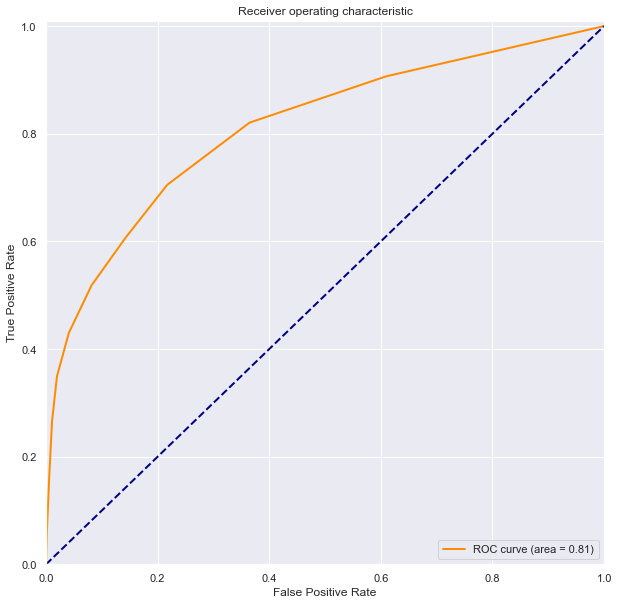

In [28]:
show_metrics(rf_clsfr, features_valid, target_valid,"Случайный лес:" )
show_roc_curve(rf_clsfr, features_valid, target_valid)

Логистическая регрессия:
Precision: 0.625
Recall: 0.19656019656019655
F1: 0.29906542056074764
ROC-AUC: 0.7745927745927746


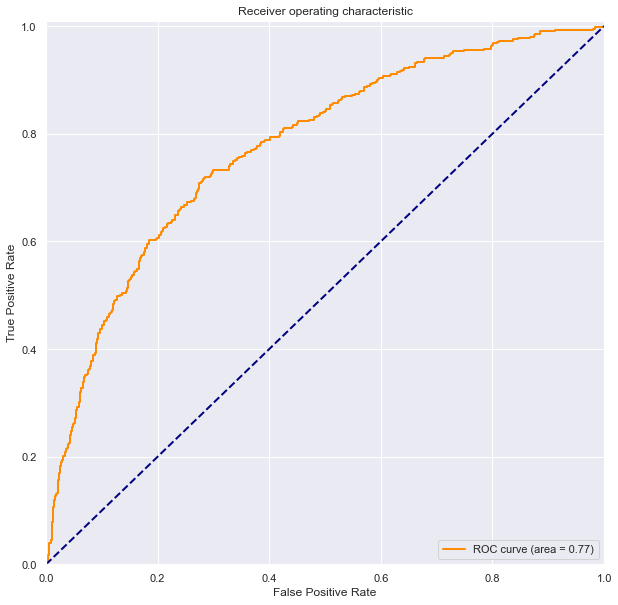

In [29]:
show_metrics(lr_clsfr, features_valid, target_valid, 'Логистическая регрессия:')
show_roc_curve(lr_clsfr, features_valid, target_valid)

Логистическая регрессия показывает `ROC-AUC` ниже, чем случайный лес. Продолжим с одной, "деревянной" моделью и попробуем для начала найти лучшие гиперпараметры методом `RandomizedSearchCV`.

In [30]:
%%time

parametrs = { 'n_estimators': range (10, 101, 10),
              'max_depth': range (1,13, 1),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,1) }

randomized_rf_clsfr = RandomizedSearchCV(rf_clsfr, 
                                         parametrs, 
                                         scoring='roc_auc', 
                                         cv=10,
                                         random_state=42)
randomized_rf_clsfr.fit(features_train, target_train)

Wall time: 16.9 s


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_estimators=10,
                                                    random_state=42),
                   param_distributions={'max_depth': range(1, 13),
                                        'min_samples_leaf': range(1, 8),
                                        'min_samples_split': range(2, 10),
                                        'n_estimators': range(10, 101, 10)},
                   random_state=42, scoring='roc_auc')

In [31]:
randomized_rf_clsfr.best_params_

{'n_estimators': 70,
 'min_samples_split': 4,
 'min_samples_leaf': 3,
 'max_depth': 10}

In [32]:
show_metrics(randomized_rf_clsfr, features_valid, target_valid,"Случайный лес:" )

Случайный лес:
Precision: 0.7990654205607477
Recall: 0.4201474201474201
F1: 0.5507246376811594
ROC-AUC: 0.8714029900470579


**Вывод по шагу 2:**

Подбор гиперпараметров помог поднять метрику `ROC-AUC`, но не дал нам ощутимого прироста в F1. Необходимо воспользоваться другими способами повышения качества модели. При проверке балансов классов в нашей выборке мы увидели, что искомый класс составляет всего 20%. Изменим баланс классов вручную и проверим поможет ли это нашей модели стать лучше.

## Борьба с дисбалансом

### Up-sampling

Первым методом, который мы попробуем будет увеличение искомого класса - `upsampling`. Мы возьмем наши выборки, отделим строки, где целевой признак равен 1 и продублируем их 4 раза, после чего перемешаем выборки и обучим на них нашу модель.

In [33]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, 
        target_upsampled, 
        random_state=12345)
    
    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(target_upsampled.mean())

0.5059468404178302


In [34]:
rndmzd_upsampled_rf_clsfr = randomized_rf_clsfr
rndmzd_upsampled_rf_clsfr.fit(features_upsampled, target_upsampled)

show_metrics(rndmzd_upsampled_rf_clsfr, features_train, target_train, "Случайный лес - тренировочная выборка:" )
show_metrics(rndmzd_upsampled_rf_clsfr, features_valid, target_valid, "Случайный лес - валидационная выборка:" )

Случайный лес - тренировочная выборка:
Precision: 0.8315935977731385
Recall: 0.9771054783319706
F1: 0.8984962406015037
ROC-AUC: 0.9945608479990058
Случайный лес - валидационная выборка:
Precision: 0.579175704989154
Recall: 0.6560196560196561
F1: 0.6152073732718895
ROC-AUC: 0.8572116029743149


Судя по просадке метрик для валидационной выборки по сравнению с тренировочной, имеется довольно сильный эффект переобучения. Но даже так модель показывает неплохие результаты. 

### Down-sampling

Посмотрим как себя будет вести модель, если мы сравняем баланс классов путем отрезания части нецелевого класса. Сделаем `downsampling`.

In [35]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
print(target_upsampled.mean())

0.5059468404178302


In [36]:
rndmzd_downsampled_rf_clsfr = randomized_rf_clsfr
rndmzd_downsampled_rf_clsfr.fit(features_downsampled, target_downsampled)

show_metrics(rndmzd_downsampled_rf_clsfr, features_train, target_train, "Случайный лес - тренировочная выборка:" )
show_metrics(rndmzd_downsampled_rf_clsfr, features_valid, target_valid, "Случайный лес - валидационная выборка:" )

Случайный лес - тренировочная выборка:
Precision: 0.569206008583691
Recall: 0.8675388389206868
F1: 0.687398769031422
ROC-AUC: 0.9334346181476346
Случайный лес - валидационная выборка:
Precision: 0.4944
Recall: 0.7592137592137592
F1: 0.5988372093023255
ROC-AUC: 0.8643188643188644


Так же имеет место переобучение, хоть и не такое сильное, как при увеличенной выборке. Последнее, что нам осталось проверить - как себя покажет модель, которая автоматически подберет веса для классов. Воспользуемся параметром модели `class_weight = 'Balanced'`

### class_weight = 'balanced'

In [37]:
randomized_rf_clsfr.best_params_

{'n_estimators': 70,
 'min_samples_split': 4,
 'min_samples_leaf': 3,
 'max_depth': 10}

In [38]:
rf_clsfr_balanced = RandomForestClassifier(random_state = 42,
                                           n_estimators = 70,
                                           min_samples_leaf = 3,
                                           min_samples_split = 4,
                                           max_depth = 10,
                                           class_weight='balanced')


In [39]:
rf_clsfr_balanced.fit(features_train, target_train)

show_metrics(rf_clsfr_balanced, features_train, target_train, "Случайный лес - тренировочная выборка:" )
show_metrics(rf_clsfr_balanced, features_valid, target_valid, "Случайный лес - валидационная выборка:" )

Случайный лес - тренировочная выборка:
Precision: 0.7367256637168141
Recall: 0.8168438266557645
F1: 0.7747188832880961
ROC-AUC: 0.9588204655347211
Случайный лес - валидационная выборка:
Precision: 0.6013363028953229
Recall: 0.6633906633906634
F1: 0.6308411214953271
ROC-AUC: 0.8647862037692546


**Вывод по шагу 3:**

||Up-sampled|||Down-sampled|||Balanced|||
|:--|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
||Train|Valid|Delta|Train|Valid|Delta|Train|Valid|Delta|
|F1-score|0.898|0.615|0.283|0.687|0.598|0.088|0.770|0.636|0.133|
|AUC|0.994|0.857|0.137|0.933|0.864|0.069|0.958|0.863|0.094|


Как видно из таблице наименьшее изменение метрик (=наименьшее переобучение) имеет модель обученная на `down-sample` выборке. При этом ее показатели AUC-ROC и F1-score не сильно хуже, чем у других моделей. Но на валидационной выборке обе метрики выше у модели, для которой балансировка классов делалась встроенным методом. 

Давайте посмотрим какая из этих двух моделей покажет максимальный F1-score на тестовой выборке при подборе порога.

## Тестирование модели

Напишем функцию, которая будет подбирать наилучший порог для наших моделей. Для начала функция переберет пороги от 0 до 0.9 с шагом 0.1, чтобы нащупать диапазон в котором F1-score максимален. Получив это грубое приближение, функция пройдется частым шагом по диапозону "грубый порог" +- 0.1.

In [40]:
def best_treshhold_choice(model, features, target, model_name):
    probabilities = model.predict_proba(features)
    probabilities_one = probabilities[:, 1]
    
    #Stage1 - choising best treshhold in range 0-1 with step 0.1
    stage1_best_trhld = 0
    stage1_best_f1 = 0
    for threshold in np.arange(0, 1, 0.1):
        predicted = probabilities_one > threshold
        f_score = f1_score(target, predicted)
        if f_score > stage1_best_f1:
            stage1_best_trhld = threshold
            stage1_best_f1 = f_score
            
    #Stage2 - choising best treshhold in range stage1_best_trhld +- 0.1 with step 0.005
    best_recall = 0
    best_precision = 0
    best_threshold = 0
    best_f1_score = 0
    for threshold in np.arange(stage1_best_trhld - 0.1, stage1_best_trhld + 0.1, 0.005):
        predicted = probabilities_one > threshold 
        precision = precision_score(target, predicted) 
        recall = recall_score(target, predicted)
        f_score = f1_score(target, predicted)
        if f_score > best_f1_score:
            best_recall = recall
            best_precision = precision
            best_threshold = threshold
            best_f1_score = f_score
            
    print(f'Для модели "{model_name}"')
    print("Лучший порог = {:.4f}  Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(
            best_threshold, best_precision, best_recall, best_f1_score))

Запустим функцию для наших моделей.

In [41]:
best_treshhold_choice(rf_clsfr_balanced, 
                      features_test, 
                      target_test, 
                      'Сбалансированный через внутренний метод случайный лес')

Для модели "Сбалансированный через внутренний метод случайный лес"
Лучший порог = 0.4950  Точность = 0.609, Полнота = 0.671, F1-мера = 0.639


In [42]:
best_treshhold_choice(rndmzd_downsampled_rf_clsfr, 
                      features_test, 
                      target_test, 
                      'Сбалансированный через уменьшение выборки метод случайный лес')

Для модели "Сбалансированный через уменьшение выборки метод случайный лес"
Лучший порог = 0.5800  Точность = 0.598, Полнота = 0.695, F1-мера = 0.643


Сбалансированный через внутренний метод случайный лес
Precision: 0.6099773242630385
Recall: 0.6609336609336609
F1: 0.6344339622641508
ROC-AUC: 0.8690770894160724


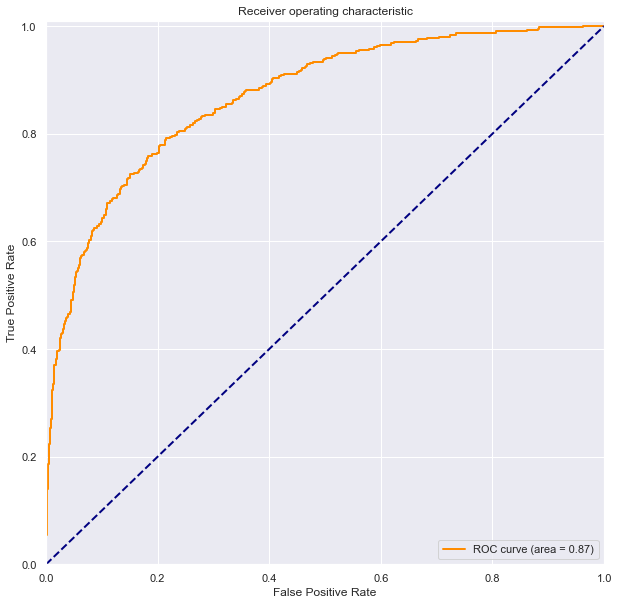

Сбалансированный через уменьшение выборки метод случайный лес
Precision: 0.4945054945054945
Recall: 0.773955773955774
F1: 0.603448275862069
ROC-AUC: 0.871659024201397


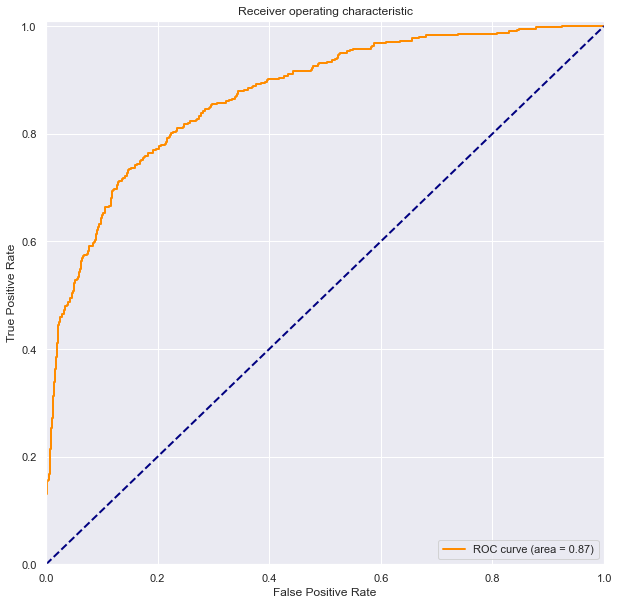

In [43]:
show_metrics(rf_clsfr_balanced, 
             features_test, 
             target_test, 
             "Сбалансированный через внутренний метод случайный лес" )
show_roc_curve(rf_clsfr_balanced, features_test, target_test)

show_metrics(rndmzd_downsampled_rf_clsfr,
             features_test, 
             target_test,
             "Сбалансированный через уменьшение выборки метод случайный лес" )
show_roc_curve(rndmzd_downsampled_rf_clsfr, features_test, target_test)

## Общий вывод:

Обе модели, вошедшие в финал нашего соревнования, показали практически идентичный результат по метрике `ROC-AUC`. Но, при подгонке порога, в лидеры выходит модель обученная на данных, сбалансированных по методу `Down-sampling`. Балансировка порога помогла поднять `ROC-AUC` на 6 пунктов по сравнению с простой моделью. А конечный результат по метрике `F1-score` улучшился на 10 пунктов.